In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit
from sklearn import mixture

from astroML.plotting.tools import draw_ellipse
from xdgmm import XDGMM
import extreme_deconvolution

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

# Kepler


 binaries from here:

http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/142/160/v3

double x-matched to Gaia DR2 & B-J Distances

http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I/347

In [168]:
# file = '1540938945496A.csv'
file = '1543957677477A.csv'
df = pd.read_csv(file)

df.columns

Index(['angDist', 'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest',
       'B_rest', 'rlen', 'ResFlag', 'ModFlag', 'angDist.2', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj.1',
       'errHalfMin.1', 'errPosAng.1', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag',

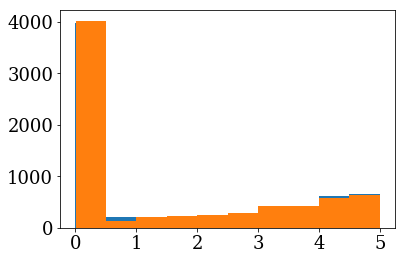

In [170]:
_ = plt.hist(df['angDist'])
_ = plt.hist(df['angDist.1'])

In [171]:
# ok = ((df['angDist'] < 0.3) & (df['parallax_error'] / df['parallax'] < 0.05) & 
#       (df['phot_g_mean_flux_error'] / df['phot_g_mean_flux'] < 0.01))

ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.02) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.02) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.02) & 
              (df['angDist'] < 0.5) & (df['angDist.1'] < 0.5))[0]
ok.shape # this is most of the true EBs

(2346,)

Text(0.5,1,'Kepler EBs')

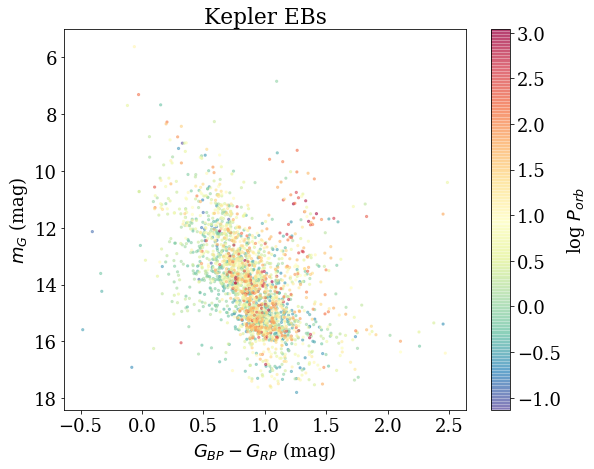

In [6]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok], 
            c=np.log10(df['Per'][ok]), cmap=cmap, s=5, alpha=0.5)
plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
plt.ylabel('$m_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')

In [7]:
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = 'MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

# mist_ms1 = np.where((mist['phase']==0) & 
#                     (mist['log10_isochrone_age_yr'] == 9.) & 
#                     (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]

mist_ms1 = np.where((mist['phase'] < 3) & (mist['log10_isochrone_age_yr'] == 8.5))[0][::-1]
mist_ms2 = np.where((mist['phase'] < 3) & (mist['log10_isochrone_age_yr'] == 9.5))[0][::-1]

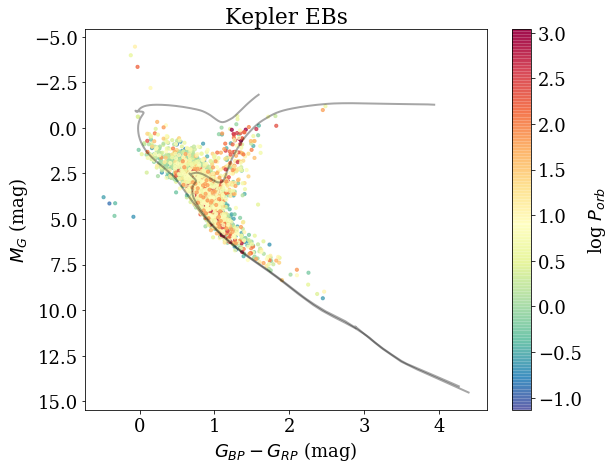

In [172]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)
plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Kepler EBs')

# plt.xlim(-1,3)
# plt.ylim(10,-5)
plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

Text(0.5,1,'Kepler EBs')

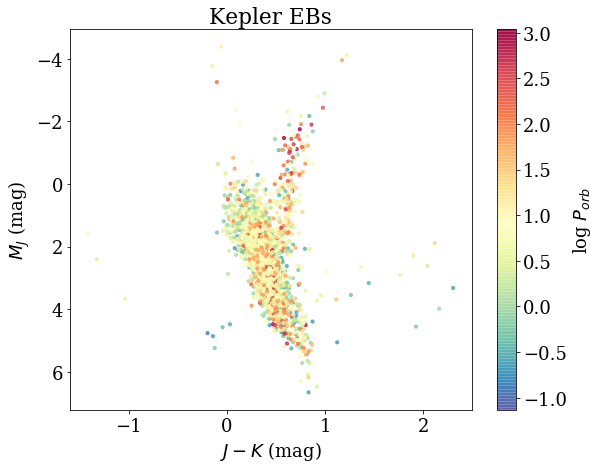

In [173]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df['Jmag'][ok] - df['Kmag'][ok], df['Jmag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)
plt.ylabel('$M_J$ (mag)')

plt.xlabel('$J-K$ (mag)')
plt.title('Kepler EBs')



# Catalina

another catalog to look at is Catalina:

http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJS/213/9/table3

In [9]:
file = '1540942562357A.csv'
df2 = pd.read_csv(file)

df2.columns

Index(['angDist', 'ra_epoch2000', 'dec_epoch2000', 'errHalfMaj', 'errHalfMin',
       'errPosAng', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest', 'B_rest',
       'rlen', 'ResFlag', 'ModFlag', '_RAJ2000', '_DEJ2000', 'CRTS', 'RAJ2000',
       'DEJ2000', '<Vmag>', 'Per', 'Vamp', 'Cl', 'f_Cl', 'Simbad'],
      dtype='object')

In [10]:
ok2 = np.where(np.isfinite(df2['parallax']) & # this is basically the same as the TGAS file...
               (df2['parallax_error']/df2['parallax'] < 0.1) &
               (df2['ModFlag'] == 1) & 
               (df2['ResFlag'] == 1) &
               np.isfinite(df2['bp_rp']) & 
               (df2['phot_bp_mean_flux_error']/df2['phot_bp_mean_flux'] < 0.02) & 
               (df2['phot_rp_mean_flux_error']/df2['phot_rp_mean_flux'] < 0.02) & 
               (df2['phot_g_mean_flux_error']/df2['phot_g_mean_flux'] < 0.02) & 
               (df2['angDist'] < 0.5) &
               np.isfinite(df2['Per']))[0]
ok2.shape # this is most of the true EBs

(8863,)

Text(0.5,1,'Catalina EBs')

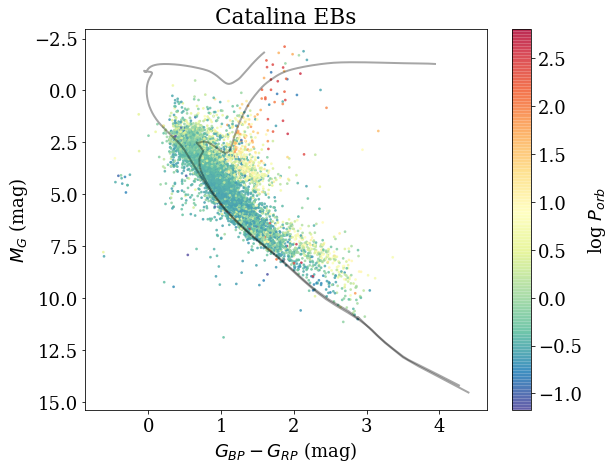

In [11]:

plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

plt.scatter(df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5, 
            c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
         mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


plt.gca().invert_yaxis()

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)

plt.ylabel('$M_G$ (mag)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Catalina EBs')

# plt.xlim(-1,3)
# plt.ylim(10,-5)
# plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

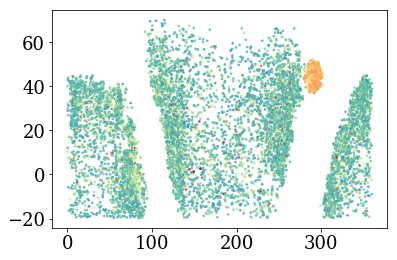

In [12]:
plt.scatter(df2['ra'][ok2], df2['dec'][ok2], c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.scatter(df['ra'][ok], df['dec'][ok], c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=3)

In [13]:

# plt.figure(figsize=(9,7))
# cmap = plt.cm.Spectral_r

# plt.scatter(df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5, 
#             c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

# plt.scatter(df['bp_rp'][ok], df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
#             c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)


# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
#          mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.35)

# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms2] - mist['Gaia_RP_DR2Rev'].values[mist_ms2], 
#          mist['Gaia_G_DR2Rev'].values[mist_ms2], c='k', lw=2, alpha=0.35)


# plt.gca().invert_yaxis()

# cb = plt.colorbar()
# cb.set_label('log $P_{orb}$')
# # cb.set_clim(-1.2,3)

# plt.ylabel('$M_G$ (mag)')

# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.title('Kepler & Catalina EBs')

# plt.xlim(-1,3)
# plt.ylim(11,-2)
# # plt.savefig('Kepler_EBs'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

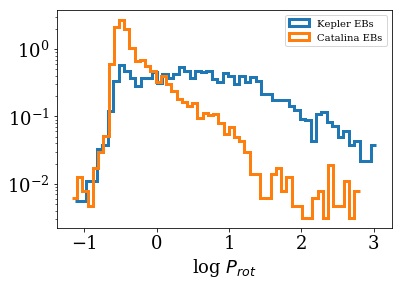

In [14]:
_ = plt.hist(np.log10(df['Per'][ok]), normed=True, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), normed=True, histtype='step', lw=3, bins=55, label='Catalina EBs')

plt.xlabel('log $P_{rot}$')
plt.yscale('log')
plt.legend(fontsize=10)

In [15]:
from matplotlib.colors import LogNorm

In [16]:
# concatenate the two datasets into the final training set
X_train = np.vstack([df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5]).T

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=64, covariance_type='full')
clf.fit(X_train)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

/Users/james/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


(15, -5)

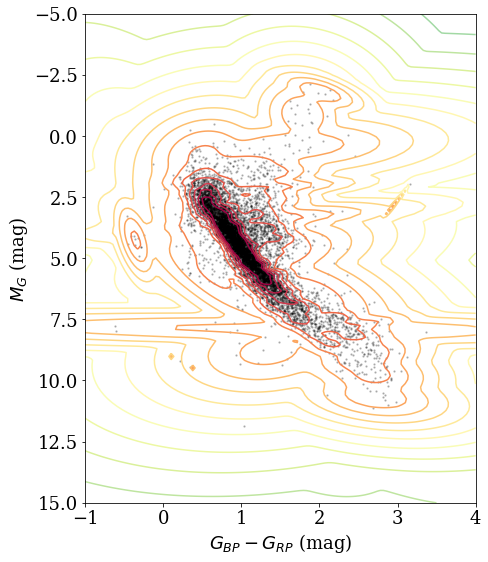

In [17]:
plt.figure(figsize=(7,9))

cmap = plt.cm.Spectral

x = np.linspace(-1., 4., 128)
y = np.linspace(-5., 15., 128)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 22), cmap=cmap)

plt.scatter(df2['bp_rp'][ok2], df2['phot_g_mean_mag'][ok2] - 5. * np.log10(df2['rest'].values[ok2]) + 5, 
            c='k', alpha=0.2, s=2)

plt.ylabel('$M_G$ (mag)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.xlim(-1,4)
plt.ylim(15,-5)


In [18]:
# I want to convert this to JHK colors, but Simbad's Xmatch is not letting me upload a file, 
# so I have to match Catalina directly to 2MASS, and join here (for now)
x2m = pd.read_csv('Cx2m.csv')
x2m.columns

Index(['angDist', '_RAJ2000', '_DEJ2000', 'CRTS', 'RAJ2000', 'DEJ2000',
       '<Vmag>', 'Per', 'Vamp', 'Cl', 'f_Cl', 'Simbad', '2MASS', 'RAJ2000.1',
       'DEJ2000.1', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag',
       'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD'],
      dtype='object')

In [19]:
df2.shape

(59096, 57)

In [20]:
x2m.shape

(43534, 28)

In [21]:
cata = pd.merge(x2m, df2, left_on='CRTS', right_on='CRTS')

In [22]:
cata.columns

Index(['angDist_x', '_RAJ2000_x', '_DEJ2000_x', 'CRTS', 'RAJ2000_x',
       'DEJ2000_x', '<Vmag>_x', 'Per_x', 'Vamp_x', 'Cl_x', 'f_Cl_x',
       'Simbad_x', '2MASS', 'RAJ2000.1', 'DEJ2000.1', 'errHalfMaj_x',
       'errHalfMin_x', 'errPosAng_x', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD', 'angDist_y',
       'ra_epoch2000', 'dec_epoch2000', 'errHalfMaj_y', 'errHalfMin_y',
       'errPosAng_y', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       'angDist.1'

In [23]:
okC = np.where(np.isfinite(cata['parallax']) & # this is basically the same as the TGAS file...
              (cata['parallax_error']/cata['parallax'] < 0.1) &
              (cata['ModFlag'] == 1) & 
              (cata['ResFlag'] == 1) &
              np.isfinite(cata['bp_rp']) & 
              (cata['phot_bp_mean_flux_error']/cata['phot_bp_mean_flux'] < 0.02) & 
              (cata['phot_rp_mean_flux_error']/cata['phot_rp_mean_flux'] < 0.02) & 
              (cata['phot_g_mean_flux_error']/cata['phot_g_mean_flux'] < 0.02) & 
              (cata['angDist_y'] < 0.5) & 
              (cata['e_Jmag'] < 0.05) & 
              (cata['e_Kmag'] < 0.05) &
              (cata['e_Jmag'] > 0) &
              (cata['e_Kmag'] > 0) & 
              (cata['Jmag'] - cata['Kmag'] > -0.5) &
              (cata['Jmag'] - cata['Kmag'] < 2) &
              np.isfinite(cata['Per_y']))[0]
okC.shape # this is most of the true EBs

(7591,)

/Users/james/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


(15, -5)

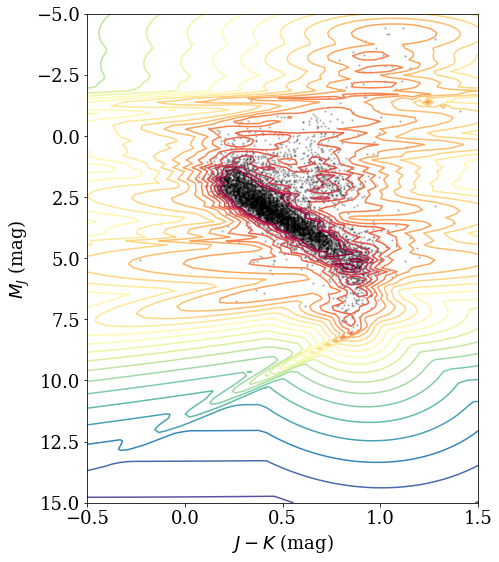

In [24]:
plt.figure(figsize=(7,9))
cmap = plt.cm.Spectral


# concatenate the two datasets into the final training set
X_train = np.vstack([cata['Jmag'][okC]-cata['Kmag'][okC], cata['Jmag'][okC] - 5. * np.log10(cata['rest'].values[okC]) + 5]).T

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=96, covariance_type='full')
clf.fit(X_train)

x = np.linspace(-1., 4., 128)
y = np.linspace(-5., 15., 128)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 22), cmap=cmap)


plt.scatter(cata['Jmag'][okC]-cata['Kmag'][okC], 
            cata['Jmag'][okC] - 5. * np.log10(cata['rest'].values[okC]) + 5, 
            c='k', alpha=0.2, s=2)

plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)
plt.ylim(15,-5)



## ASAS-SN

https://asas-sn.osu.edu/variables

In [25]:
asas = pd.read_csv('asassn-catalog.csv')
asas.columns

/Users/james/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['ASAS-SN Name', 'Other Names', 'LCID', 'RAJ2000', 'DEJ2000',
       'Mean VMag', 'Amplitude', 'Period', 'Type', 'Url', 'Reference', 'Dist',
       'Parallax', 'Parallax Error', 'Gmag', 'Bpmag', 'Rpmag', 'Jmag', 'Hmag',
       'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'BP-RR', 'J-K', 'W1-W2',
       'W3-W4', 'Sllk Statistic', 'RF Regression Score',
       'Classification Probability', 'Epoch (HJD)'],
      dtype='object')

In [26]:
# and because ASAS-SN rocks, they *already* have both 2MASS and Gaia included 
# but no errors, oh well

In [27]:
sum((asas['Type'] == 'EA') | (asas['Type'] == 'EB') | (asas['Type'] == 'EW'))

64949

In [28]:
sum(asas['Classification Probability'] < .5)

61125

In [29]:
okA = np.where((asas['Mean VMag'] < 16) & 
               (asas['Jmag'] - cata['Kmag'] > -0.5) &
               (asas['Jmag'] - cata['Kmag'] < 2) &
               (asas['Classification Probability'] > 0.9) & 
               (asas['Type'] == 'EA') | (asas['Type'] == 'EB') | (asas['Type'] == 'EW'))[0]
okA.shape # this is most of the true EBs

(46876,)

In [30]:
AokA = np.where((asas['Parallax Error'][okA]/asas['Parallax'][okA] < 0.1) &
                np.isfinite(asas['Jmag'][okA]) & 
                np.isfinite(asas['Kmag'][okA]) & 
                (asas['Jmag'][okA] - asas['Kmag'][okA] > -0.5) &
                (asas['Jmag'][okA] - asas['Kmag'][okA] < 2) &
                (asas['Parallax'][okA] > 0) &
                np.isfinite(asas['Parallax'][okA]))[0]
print(AokA.shape)

(32371,)


/Users/james/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


(7, -5)

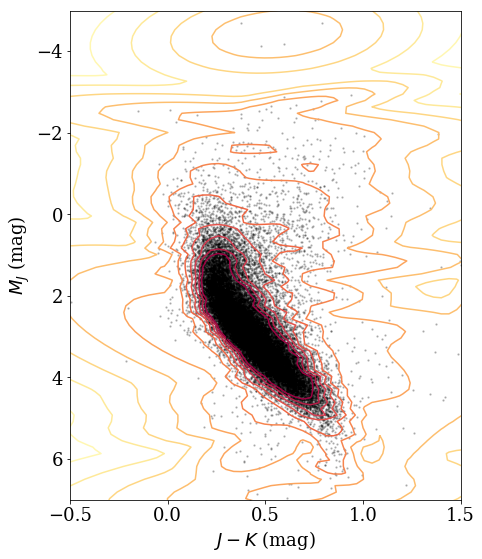

In [43]:
plt.figure(figsize=(7,9))
cmap = plt.cm.Spectral


# concatenate the two datasets into the final training set
X_train = np.vstack([asas['Jmag'][okA[AokA]] - asas['Kmag'][okA[AokA]], 
                     (asas['Jmag'][okA[AokA]] - 5. * np.log10(1000./asas['Parallax'][okA[AokA]].values) + 5)]).T

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=96, covariance_type='full')
clf.fit(X_train)

x = np.linspace(-1., 4., 128)
y = np.linspace(-5., 15., 128)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 22), cmap=cmap)

# for i in range(clf.n_components):
#         draw_ellipse(clf.means_[i], clf.covariances_[i], scales=[2], alpha=0.2)


plt.scatter(asas['Jmag'][okA[AokA]] - asas['Kmag'][okA[AokA]], 
            asas['Jmag'][okA[AokA]] - 5. * np.log10(1000./asas['Parallax'][okA[AokA]].values) + 5, 
            alpha=0.2, s=2, c='k')

# plt.scatter(cata['Jmag'][okC]-cata['Kmag'][okC], 
#             cata['Jmag'][okC] - 5. * np.log10(cata['rest'].values[okC]) + 5, 
#             alpha=0.2, s=2)

plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)
plt.ylim(7,-5)




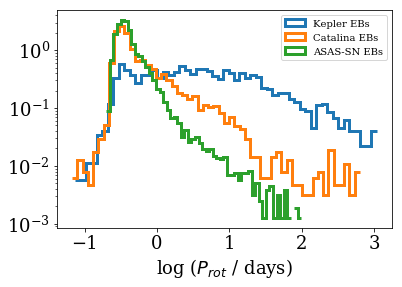

In [218]:
_ = plt.hist(np.log10(df['Per'][ok]), normed=True, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), normed=True, histtype='step', lw=3, bins=55, label='Catalina EBs')
_ = plt.hist(np.log10(asas['Period'][okA[AokA]].astype('float')), normed=True, histtype='step', lw=3, bins=55, label='ASAS-SN EBs')
plt.xlabel('log ($P_{rot}$ / days)')
plt.yscale('log')
plt.legend(fontsize=10)
plt.savefig('per_hist_compare.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

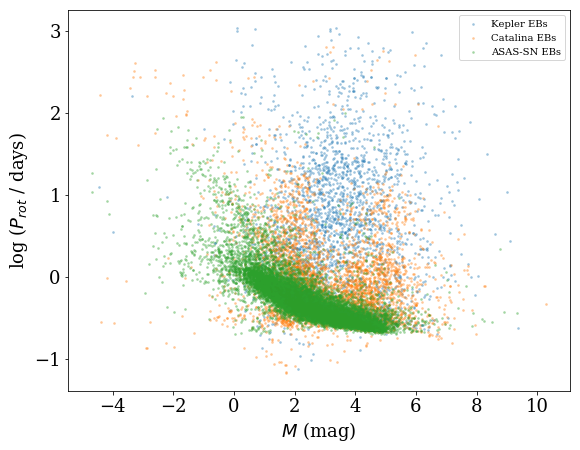

In [33]:
plt.figure(figsize=(9,7))
plt.scatter(df['phot_g_mean_mag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            np.log10(df['Per'][ok]), label='Kepler EBs', s=3, alpha=0.3)


plt.scatter(cata['Jmag'][okC] -  5. * np.log10(cata['rest'].values[okC]) + 5, 
            np.log10(cata['Per_x'][okC]), label='Catalina EBs', s=3, alpha=0.3)

plt.scatter(asas['Jmag'][okA[AokA]] - 5. * np.log10(1000./asas['Parallax'][okA[AokA]].values) + 5, 
            np.log10(asas['Period'][okA[AokA]].astype('float')), label='ASAS-SN EBs', s=3, alpha=0.3)


plt.xlabel('$M$ (mag)')
plt.ylabel('log ($P_{rot}$ / days)')
plt.legend(fontsize=10)

# XDGMM Compare
Compare to the 128 XDGMM model from Anderson+2018 using Gaia DR1

In [41]:
def plotXdgmm(xdgmm, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
#         plt.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)
        plt.plot(points[0,:], (np.log10(points[1,:])-2)*5., 
                 c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


(7, -5)

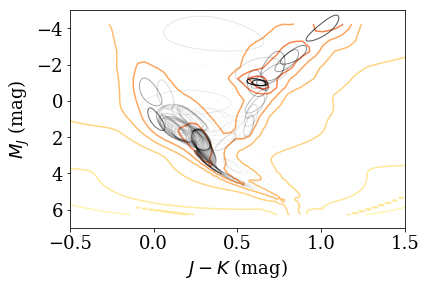

In [214]:
#read in gaussian parameters (from Dr. Lauren Anderson)
xdgmmL = XDGMM(filename='xdgmm.128gauss.dQ0.05.10th.2MASS.All.npz.fit')

x = np.linspace(-1., 4., 128)
y = np.linspace(0, 1800, 128)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

XXerr = np.zeros([XX.shape[0], XX.shape[1], XX.shape[1]])
logprob, resp = xdgmmL.score_samples(XX, XXerr)

Z = -logprob
Z = Z.reshape(X.shape)


cmap = plt.cm.Spectral
plotXdgmm(xdgmmL)

CS = plt.contour(X, (np.log10(Y)-2.)*5., Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 22), cmap=cmap)


plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)

plt.ylim(7,-5)



/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


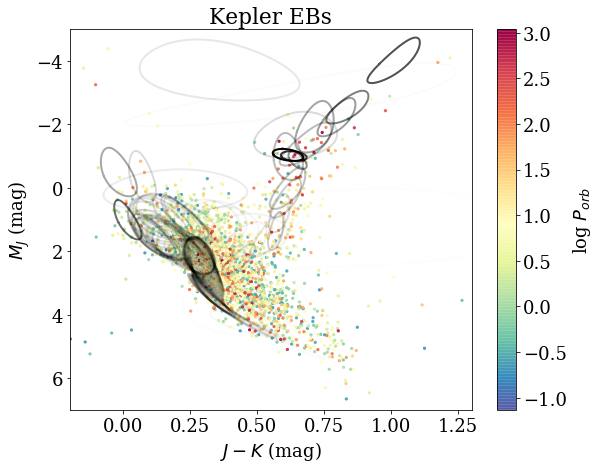

In [217]:
#compare the XDGMM to the Kepler EB data


plt.figure(figsize=(9,7))
cmap = plt.cm.Spectral_r

# plt.errorbar(df['Jmag'][ok] - df['Kmag'][ok], df['Jmag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
#              xerr=(df['e_Jmag'][ok]**2 + df['e_Kmag'][ok]**2)**0.5, yerr=df['e_Jmag'][ok], linestyle='', 
#              marker='', alpha=0.2)

# CS = plt.contour(X, (np.log10(Y)-2.)*5., Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 22), cmap=cmap)


plt.scatter(df['Jmag'][ok] - df['Kmag'][ok], df['Jmag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.85, s=5)


plotXdgmm(xdgmmL, lw=2)

cb = plt.colorbar()
cb.set_label('log $P_{orb}$')
cb.set_clim(-1.2,3)
plt.ylabel('$M_J$ (mag)')

plt.xlabel('$J-K$ (mag)')
plt.title('Kepler EBs')

plt.xlim(-0.2, 1.3)
plt.ylim(7,-5)
plt.savefig('Kepler_EBs_compare.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

If we want to directly compare (i.e. divide) the XDGMM model w/ the big GMM one I've hastily built, we'll need to make sure they're on the same grid!

Out of whimsy, I'll adopt the modified y-axis grid the XDGMM paper uses

In [106]:
# grid to use in BOTH cases
x = np.linspace(-1., 4., 128)
y = np.linspace(0, 1800, 128)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

XXerr = np.zeros([XX.shape[0], XX.shape[1], XX.shape[1]])
logprob, resp = xdgmmL.score_samples(XX, XXerr)

# ZXD = -logprob
ZXD = np.exp(logprob)
ZXD = ZXD.reshape(X.shape)

/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(7, -5)

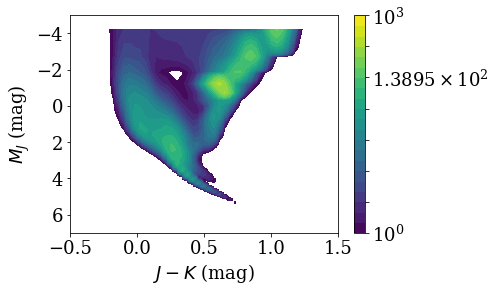

In [116]:
plt.contourf(X, (np.log10(Y)-2.)*5., (ZXD * 1e4), norm=LogNorm(vmin=1.0, vmax=1000.0),
             levels=np.logspace(0, 3, 22))

cb = plt.colorbar()
plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)
plt.ylim(7,-5)

In [183]:
### use ASAS binaries
# M_J_asas = (asas['Jmag'][okA[AokA]] - 5. * np.log10(1000./asas['Parallax'][okA[AokA]].values) + 5)

# X_train = np.vstack([asas['Jmag'][okA[AokA]] - asas['Kmag'][okA[AokA]], 
#                      10.0**(M_J_asas/5. + 2)]).T


### use Kepler binaries
M_J_Kep = df['Jmag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5
# plt.scatter(df['Jmag'][ok] - df['Kmag'][ok], , 
#             c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=10)
X_train = np.vstack([df['Jmag'][ok] - df['Kmag'][ok], 
                     10.0**(M_J_Kep/5. + 2)]).T


# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=32, covariance_type='full')
gmm.fit(X_train)

Z = np.exp(gmm.score_samples(XX))
Z = Z.reshape(X.shape)

/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


(7, -5)

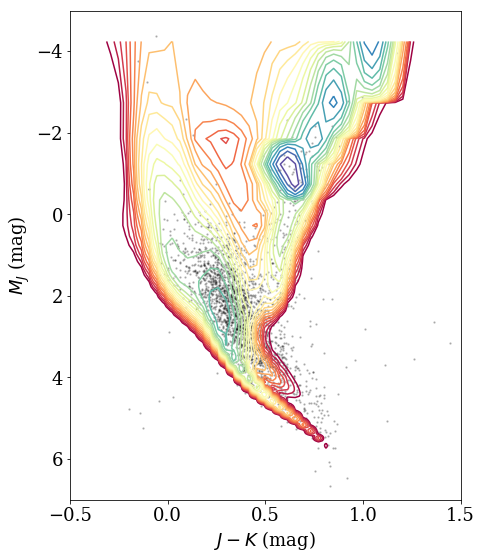

In [184]:
plt.figure(figsize=(7,9))
cmap = plt.cm.Spectral

### plot the XDGMM
# plotXdgmm(xdgmmL, c='r')

CSXD = plt.contour(X, (np.log10(Y)-2.)*5., ZXD*np.size(AokA), norm=LogNorm(vmin=1.0, vmax=1000.0),
                   levels=np.logspace(0, 3, 22), cmap=cmap)


### plot the DATA (GMM)
# CS = plt.contour(X, (np.log10(Y)-2.)*5., Z*np.size(AokA), norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 22))

# plt.scatter(asas['Jmag'][okA[AokA]] - asas['Kmag'][okA[AokA]], 
#             asas['Jmag'][okA[AokA]] - 5. * np.log10(1000./asas['Parallax'][okA[AokA]].values) + 5, 
#             alpha=0.2, s=2, c='k')
plt.scatter(df['Jmag'][ok] - df['Kmag'][ok], df['Jmag'][ok] - 5. * np.log10(df['rest'].values[ok]) + 5, 
            c='k', alpha=0.2, s=2)


plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)
plt.ylim(7,-5)



/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


(6.5, -3)

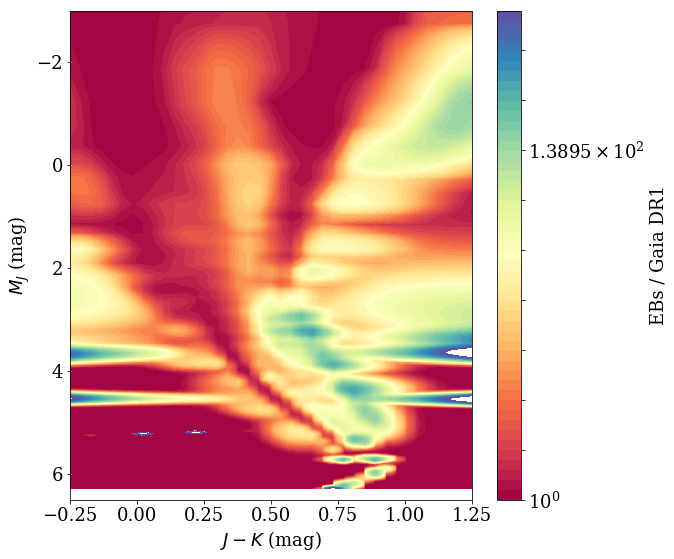

In [185]:
plt.figure(figsize=(9,9))
cmap = plt.cm.Spectral


# plt.contour(X, (np.log10(Y)-2.)*5., Z*np.size(AokA), norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 22), colors='w', alpha=0.25)

# plotXdgmm(xdgmmL, c='white')

plt.contourf(X, (np.log10(Y)-2.)*5., (Z*np.size(AokA) / (ZXD*np.size(AokA) ))+1, norm=LogNorm(),
                   levels=np.logspace(0, 3, 50), cmap=plt.cm.Spectral)

cb = plt.colorbar()
cb.set_label('EBs / Gaia DR1')

plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.25,1.25)
plt.ylim(6.5,-3)


/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


(7, -5)

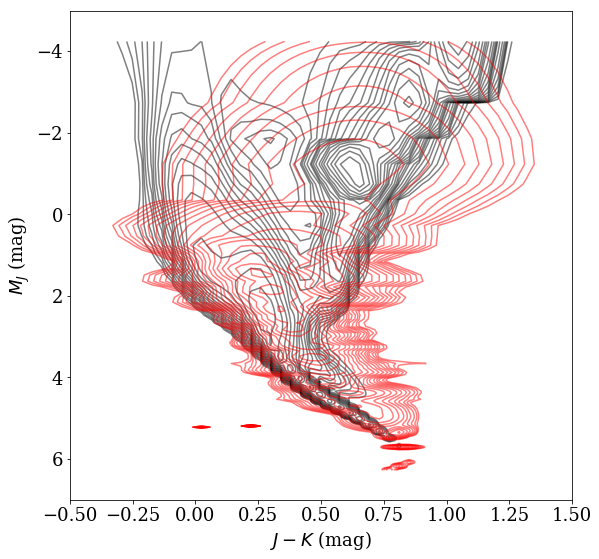

In [186]:

plt.figure(figsize=(9,9))

CSXD = plt.contour(X, (np.log10(Y)-2.)*5., ZXD*np.size(AokA), norm=LogNorm(vmin=1.0, vmax=1000.0),
                   levels=np.logspace(0, 3, 22), colors='k', alpha=0.5)


### plot the DATA (GMM)
CS = plt.contour(X, (np.log10(Y)-2.)*5., Z*np.size(AokA), norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 22), colors='r',alpha=0.5)

plt.ylabel('$M_J$ (mag)')
plt.xlabel('$J-K$ (mag)')
plt.xlim(-0.5,1.5)
plt.ylim(7,-5)

